# Experiments for Report and Presentation

This script runs through each of the models discussed in the results and calculates. The purpose of this script is not to be optimal in terms of efficiency but to calculate all the results sequentially.

## Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math
from keras.layers import LSTM, Bidirectional, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras import callbacks
import pickle

Using TensorFlow backend.


In [3]:
# load csv which is already in a convenient format and make some more changes, final result is shown below
PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
temp = df.set_index(['zone_id', 'year', 'month', 'day'])

# change column names to integer hours
colname_to_int = {}
for i in list(temp.columns):
    colname_to_int[i] = int(i[1:])

# reshape the array to manageable format, result is shown below
temp = temp.rename(columns=colname_to_int)
temp = temp.stack()
temp = temp.unstack(level=0)
temp.columns.names = [None]
temp.index.names = [None, None, None, None]
df_zone = temp
temp.head(2)

1         2         3      4       5         6         7   \
2004 1 1 1  16853.0  126259.0  136233.0  484.0  6829.0  133088.0  136233.0   
         2  16450.0  123313.0  133055.0  457.0  6596.0  129909.0  133055.0   

                8        9        10       11        12       13       14  \
2004 1 1 1  3124.0  75243.0  23339.0  90700.0  118378.0  20673.0  21791.0   
         2  2956.0  67368.0  22100.0  86699.0  112480.0  19666.0  21400.0   

                 15       16       17        18       19       20  
2004 1 1 1  65970.0  28752.0  30645.0  200946.0  82298.0  79830.0  
         2  64600.0  27851.0  30461.0  195835.0  79827.0  77429.0

## Naive Predictors

In [21]:
# use data for zone 1.
data = df_zone[1].values.reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERCENT = 0.80

train_size = int(len(dataset) * TRAINING_PERCENT)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [22]:
# function that computes the mean squared error from predi
def get_naive_week_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24*7], Y[0:-24*7])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_day_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24], Y[0:-24])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_hour_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0, :].reshape(1, -1), Y[0:-1])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

mse_train_naive_hour, train_predict_naive_hour = get_naive_hour_predict_and_score_multi(0, train_Y)
mse_test_naive_hour, test_predict_naive_hour = get_naive_hour_predict_and_score_multi(0, test_Y)
mse_train_naive_day, train_predict_naive_day = get_naive_day_predict_and_score_multi(0, train_Y)
mse_test_naive_day, test_predict_naive_day = get_naive_day_predict_and_score_multi(0, test_Y)
mse_train_naive_week, train_predict_naive_week = get_naive_week_predict_and_score_multi(0, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_week_predict_and_score_multi(0, test_Y)

print("(Naive -1 hour) Training data error: %.2f MSE" % mse_train_naive_hour)
print("(Naive -1 hour) Test data error: %.2f MSE" % mse_test_naive_hour)
print("(Naive -1 day) Training data error: %.2f MSE" % mse_train_naive_day)
print("(Naive -1 day) Test data error: %.2f MSE" % mse_test_naive_day)
print("(Naive -1 week) Training data error: %.2f MSE" % mse_train_naive_week)
print("(Naive -1 week) Test data error: %.2f MSE" % mse_test_naive_week)

(Naive -1 hour) Training data error: 1443.82 MSE
(Naive -1 hour) Test data error: 1499.18 MSE
(Naive -1 day) Training data error: 3021.37 MSE
(Naive -1 day) Test data error: 3289.53 MSE
(Naive -1 week) Training data error: 4569.05 MSE
(Naive -1 week) Test data error: 5267.30 MSE


In [23]:
def get_naive_week_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24*7], Y[0:-24*7])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, pred)

def get_naive_day_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24], Y[0:-24])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, pred)

def get_naive_hour_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0, :].reshape(1, -1), Y[0:-1])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, pred)

mse_train_naive_hour, train_predict_naive_hour = get_naive_hour_predict_and_score_multi(0, train_Y)
mse_test_naive_hour, test_predict_naive_hour = get_naive_hour_predict_and_score_multi(0, test_Y)
mse_train_naive_day, train_predict_naive_day = get_naive_day_predict_and_score_multi(0, train_Y)
mse_test_naive_day, test_predict_naive_day = get_naive_day_predict_and_score_multi(0, test_Y)
mse_train_naive_week, train_predict_naive_week = get_naive_week_predict_and_score_multi(0, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_week_predict_and_score_multi(0, test_Y)

print("(Naive -1 hour) Training data error: %.2f MSE" % mse_train_naive_hour)
print("(Naive -1 hour) Test data error: %.2f MSE" % mse_test_naive_hour)
print("(Naive -1 day) Training data error: %.2f MSE" % mse_train_naive_day)
print("(Naive -1 day) Test data error: %.2f MSE" % mse_test_naive_day)
print("(Naive -1 week) Training data error: %.2f MSE" % mse_train_naive_week)
print("(Naive -1 week) Test data error: %.2f MSE" % mse_test_naive_week)

(Naive -1 hour) Training data error: 33.63 MSE
(Naive -1 hour) Test data error: 34.12 MSE
(Naive -1 day) Training data error: 45.77 MSE
(Naive -1 day) Test data error: 48.00 MSE
(Naive -1 week) Training data error: 57.22 MSE
(Naive -1 week) Test data error: 61.12 MSE


## LSTM for Future Predictions

In [24]:
# helper function to read data and preprocess it so that it feeds into Keras. 
# this create dataset function gives data_y as vector with nstep values i.e. n-day ahead prediciton
def create_dataset_nstep(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[(i + window_size):(i + window_size + nstep), 0])
    return(np.array(data_x), np.array(data_y))

In [25]:
# define a Keras model which will be trained
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    # defining a sequential layer means that more layers can simply be added on
    vanilla_rnn = Sequential()
    # add an LSTM layer
    vanilla_rnn.add(LSTM(20, input_shape = (1, window_size)))
    # add a dense layer to aggregate the dimension 20 hidden layer into nstep outputs
    vanilla_rnn.add(Dense(nstep))
    # chose the loss function, the optimizer and the metrics
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

# define the lookback perdiod which is used for training
window_size = 50
# define the prediciton perdiod which is used
nstep = 1

train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

# instantiate the model
vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
#SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))

# train the model with the early stopping callback which stops training if the validation loss does not decrease 
# for "patience" amount of epochs
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

# calculate the MSE and MAE for each set of predicitons and true values
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26900 samples, validate on 4748 samples
Epoch 1/100
 - 5s - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0546 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0328
Epoch 2/100
 - 2s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0270 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0259
Epoch 3/100
 - 2s - loss: 8.5878e-04 - mean_squared_error: 8.5878e-04 - mean_absolute_error: 0.0225 - val_loss: 9.0430e-04 - val_mean_squared_error: 9.0430e-04 - val_mean_absolute_error: 0.0233
Epoch 4/100
 - 2s - loss: 7.0867e-04 - mean_squared_error: 7.0867e-04 - mean_absolute_error: 0.0202 - val_loss: 7.6932e-04 - val_mean_squared_error: 7.6932e-04 - val_mean_absolute_error: 0.0211
Epoch 5/100
 - 3s - loss: 6.2716e-04 - mean_squared_error: 6.2716e-04 - mean_absolute_error: 0.0188 - val_loss: 6.9540e-04 - val_mean_squared_error: 6.9540e-04 - val_mean_absolute_error: 0.0197
Epoch 6/100
 

In [15]:
# show Keras model summary
vanilla_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


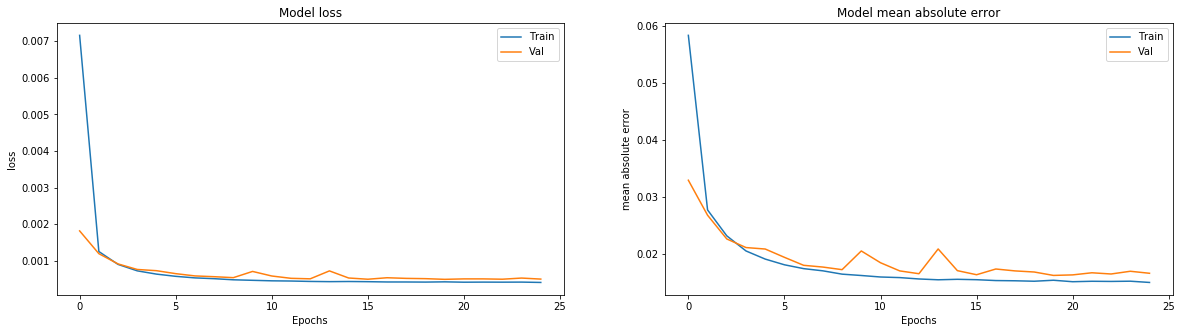

In [16]:
# plot some metrics over the training time
metrics = [['loss', 'val_loss'], ['mean_absolute_error', 
           'val_mean_absolute_error']]

plt.figure(figsize = (20, 5))
for i, x in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[x[0]])
    plt.plot(history.history[x[1]])
    plt.legend(['Train', 'Val'], loc='best')
    string_metric = (' ').join(x[0].split('_'))
    plt.xlabel("Epochs")
    plt.title('Model {}'.format(string_metric))
    plt.ylabel(string_metric)
plt.show()

All the code that follows is the same as before but with different window sizes for lookback periods and prediction lengths

In [5]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
#SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 25917 samples, validate on 4574 samples
Epoch 1/100
 - 2s - loss: 0.0126 - mse: 0.0126 - mae: 0.0820 - val_loss: 0.0110 - val_mse: 0.0110 - val_mae: 0.0789
Epoch 2/100
 - 1s - loss: 0.0081 - mse: 0.0081 - mae: 0.0677 - val_loss: 0.0117 - val_mse: 0.0117 - val_mae: 0.0802
Epoch 3/100
 - 1s - loss: 0.0079 - mse: 0.0079 - mae: 0.0668 - val_loss: 0.0126 - val_mse: 0.0126 - val_mae: 0.0825
Epoch 4/100
 - 1s - loss: 0.0077 - mse: 0.0077 - mae: 0.0659 - val_loss: 0.0111 - val_mse: 0.0111 - val_mae: 0.0799
Epoch 5/100
 - 1s - loss: 0.0076 - mse: 0.0076 - mae: 0.0651 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0803
Epoch 6/100
 - 1s - loss: 0.0073 - mse: 0.0073 - mae: 0.0639 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae: 0.0829
Epoch 00006: early stopping
Training data error: 3435.35 MSE
Test data error: 4369.16 MSE
Training data error: 50.11 MAE
Test data error: 55.95 MAE


In [6]:
vanilla_rnn.save("./../../Data/Models/lstm_1000_168.h5")

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 1000
nstep = 1
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 100
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
#SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
vanilla_rnn.save("./../../Data/Models/lstm_100_24.h5")

In [ ]:
window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 1000
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

## Bidirectional LSTM for Future Predicitons

This section is very similar to before, the difference is in the model definition which uses a bidirectional LSTM instead of a regular LSTM or GRU

In [17]:
# create a dataset by looking at values either side of a gap and concatenating them. 
# this function is not used yet, only in the next section (bidirectional LSTM for gap prediciton)
def create_dataset_nstep_bidir(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))

In [19]:
def create_dataset_nstep_bidir(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        ws_2 = int(window_size/2)
        s1 = dataset[i:(i + ws_2), 0]
        s2 = dataset[(i + ws_2 + nstep):(i + window_size + nstep), 0]
        data_x.append(np.concatenate((s1, s2)))
        data_y.append(dataset[(i + ws_2):(i + ws_2 + nstep), 0])
    return(np.array(data_x), np.array(data_y))

def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26866 samples, validate on 4742 samples
Epoch 1/100
 - 5s - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0395 - val_loss: 0.0012 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0258
Epoch 2/100
 - 3s - loss: 7.6091e-04 - mean_squared_error: 7.6091e-04 - mean_absolute_error: 0.0207 - val_loss: 9.7557e-04 - val_mean_squared_error: 9.7557e-04 - val_mean_absolute_error: 0.0234
Epoch 3/100
 - 3s - loss: 5.4092e-04 - mean_squared_error: 5.4092e-04 - mean_absolute_error: 0.0172 - val_loss: 8.3982e-04 - val_mean_squared_error: 8.3982e-04 - val_mean_absolute_error: 0.0219
Epoch 4/100
 - 3s - loss: 4.6916e-04 - mean_squared_error: 4.6916e-04 - mean_absolute_error: 0.0160 - val_loss: 6.2432e-04 - val_mean_squared_error: 6.2432e-04 - val_mean_absolute_error: 0.0184
Epoch 5/100
 - 3s - loss: 4.1323e-04 - mean_squared_error: 4.1323e-04 - mean_absolute_error: 0.0149 - val_loss: 4.5517e-04 - val_mean_squared_error: 4.5517e-04 - val_mean_absolute_error: 0.01

In [11]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 672
nstep = 168
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
#SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26196 samples, validate on 4623 samples
Epoch 1/100
 - 2s - loss: 0.0108 - mse: 0.0108 - mae: 0.0767 - val_loss: 0.0114 - val_mse: 0.0114 - val_mae: 0.0797
Epoch 2/100
 - 2s - loss: 0.0082 - mse: 0.0082 - mae: 0.0677 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0790
Epoch 3/100
 - 2s - loss: 0.0081 - mse: 0.0081 - mae: 0.0672 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0789
Epoch 4/100
 - 2s - loss: 0.0079 - mse: 0.0079 - mae: 0.0665 - val_loss: 0.0113 - val_mse: 0.0113 - val_mae: 0.0796
Epoch 5/100
 - 2s - loss: 0.0078 - mse: 0.0078 - mae: 0.0661 - val_loss: 0.0109 - val_mse: 0.0109 - val_mae: 0.0787
Epoch 6/100
 - 2s - loss: 0.0077 - mse: 0.0077 - mae: 0.0654 - val_loss: 0.0112 - val_mse: 0.0112 - val_mae: 0.0790
Epoch 7/100
 - 2s - loss: 0.0074 - mse: 0.0074 - mae: 0.0644 - val_loss: 0.0111 - val_mse: 0.0111 - val_mae: 0.0801
Epoch 00007: early stopping
Training data error: 3388.78 MSE
Test data error: 4105.26 MSE
Training data error: 50.83 MAE
Test data error: 5

In [12]:
vanilla_rnn.save("./../../Data/Models/lstm_672_168.h5")

In [ ]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep_bidir(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(Bidirectional(LSTM(20, input_shape = (1, window_size))))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

## Bidirectional LSTM for Gap Predicitons (Concatenating Data Before & After)

In [20]:
window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

Train on 26866 samples, validate on 4742 samples
Epoch 1/100
 - 5s - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0231 - val_loss: 3.3682e-04 - val_mean_squared_error: 3.3682e-04 - val_mean_absolute_error: 0.0138
Epoch 2/100
 - 3s - loss: 2.0768e-04 - mean_squared_error: 2.0768e-04 - mean_absolute_error: 0.0108 - val_loss: 2.3936e-04 - val_mean_squared_error: 2.3936e-04 - val_mean_absolute_error: 0.0118
Epoch 3/100
 - 3s - loss: 1.2895e-04 - mean_squared_error: 1.2895e-04 - mean_absolute_error: 0.0084 - val_loss: 1.1996e-04 - val_mean_squared_error: 1.1996e-04 - val_mean_absolute_error: 0.0077
Epoch 4/100
 - 3s - loss: 9.8269e-05 - mean_squared_error: 9.8269e-05 - mean_absolute_error: 0.0073 - val_loss: 1.1271e-04 - val_mean_squared_error: 1.1271e-04 - val_mean_absolute_error: 0.0076
Epoch 5/100
 - 3s - loss: 8.6943e-05 - mean_squared_error: 8.6943e-05 - mean_absolute_error: 0.0069 - val_loss: 9.4470e-05 - val_mean_squared_error: 9.4470e-05 - val_mean_absolute_err

In [ ]:

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:

window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:

window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

## Biriectional LSTM (Long Time Period)

Here there are a few experiments that were not added to the final report

In [ ]:
window_size = 1000
nstep = 24*7*4
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 1000
nstep = 24*7*4
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 4000
nstep = 24*7*4
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
window_size = 4000
nstep = 24*7*4
train_X, train_Y = create_dataset_nstep_bidir(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep_bidir(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep_bidir(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

## GRU

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(GRU(20, input_shape = (1, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

## Multivariable LSTM and Temperature Data Preprocessing

In [ ]:
PATH = r"../../Data/temperature_history.csv"
df_T = pd.read_csv(PATH)
h_df_T = df_T.set_index(['station_id', 'year', 'month', 'day'])
trans_dict = {}
for i in list(h_df_T.columns):
    trans_dict[i] = int(i[1:])
h_df_T = h_df_T.rename(columns=trans_dict)
h_df_T = h_df_T.stack()
h_df_T = h_df_T.unstack(level=0)
h_df_T.columns = h_df_T.columns.get_level_values(0)
h_df_T.columns.names = [None]
h_df_T.index.names = [None, None, None, None]

PATH = r"../../Data/temperature_solution.csv"
df_T_Sol = pd.read_csv(PATH)
h_df_T_Sol = df_T_Sol.set_index(['station_id', 'year', 'month', 'day', 'hour'])
h_df_T_Sol = h_df_T_Sol.drop(['datetime', 'date'], axis=1)
h_df_T_Sol = h_df_T_Sol.unstack(level=0)
h_df_T_Sol.columns = h_df_T_Sol.columns.get_level_values(1)
h_df_T_Sol.columns.names = [None]
h_df_T_Sol.index.names = [None, None, None, None]

zone_T = pd.concat([h_df_T, h_df_T_Sol], axis=0, join='outer', ignore_index=False, keys=None, 
          levels=None, names=None, verify_integrity=True, copy=True)

T_mean = zone_T.mean(axis=1)
#temp['T'] = T_mean
temp['T'] = pd.Series(np.concatenate([T_mean[:12].values, T_mean[0:-12].values]) , index = (T_mean.index))

zone_T.head(2)

In [ ]:
temp[[1, 'T']].plot(subplots=True)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(temp[[1, 'T']])

# Using 80% of data for training, 20% for validation.
TRAINING_PERCENT = 0.80

train_size = int(len(scaled) * TRAINING_PERCENT)
test_size = len(scaled) - train_size
train_multi, test_multi = scaled[0:train_size, :], scaled[train_size:len(scaled), :]
print("Number of samples training set: " + str((len(train_multi))))
print("Number of samples test set: " + str((len(test_multi))))

In [ ]:
def create_dataset_nstep_multi(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        sample = dataset[i:(i + window_size), :]
        data_x.append(sample)
        data_y.append(dataset[(i + window_size):(i + window_size + nstep), 0])
    return(np.array(data_x), np.array(data_y))

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 1
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 100
nstep = 1
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 50
nstep = 24
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 200
nstep = 24*7
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)

In [ ]:
def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(20, input_shape = (2, window_size)))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae'])
    return(vanilla_rnn)

window_size = 500
nstep = 24*7
train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, nstep)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

vanilla_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    score2 = math.sqrt(mean_absolute_error(orig_data, pred))
    return(score, score2, pred)

mse_train, mae_train, train_predict = get_predict_and_score_multi(vanilla_rnn, train_X, train_Y)
mse_test, mae_test, test_predict = get_predict_and_score_multi(vanilla_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("Training data error: %.2f MAE" % mae_train)
print("Test data error: %.2f MAE" % mae_test)